<a href="https://colab.research.google.com/github/isahaasasu/MAT422/blob/main/HW4_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Homework 4.1**

## Graph Modeling

In [5]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import os
import networkx as nx
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

## Laplacian Matrix

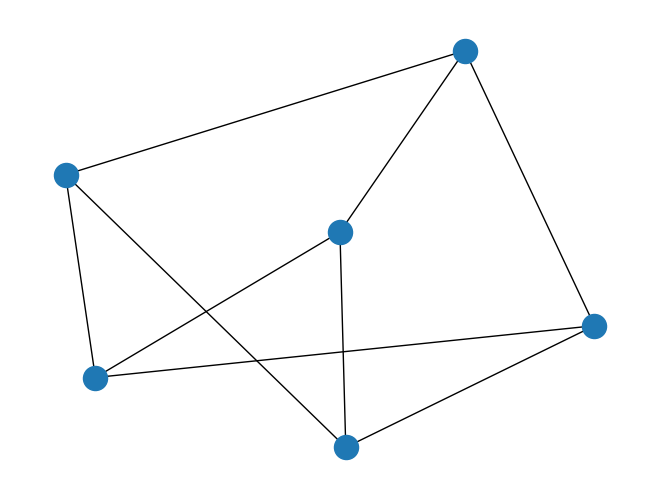

In [6]:
G = nx.random_regular_graph(3, 6)
nx.draw(G)

In [2]:
A = nx.adjacency_matrix(G).toarray()
print(A)
D = np.diag(np.ones(6)*3)
print(D)
L = D - A
print(L)

[[0 1 0 0 1 1]
 [1 0 1 1 0 0]
 [0 1 0 0 1 1]
 [0 1 0 0 1 1]
 [1 0 1 1 0 0]
 [1 0 1 1 0 0]]
[[3. 0. 0. 0. 0. 0.]
 [0. 3. 0. 0. 0. 0.]
 [0. 0. 3. 0. 0. 0.]
 [0. 0. 0. 3. 0. 0.]
 [0. 0. 0. 0. 3. 0.]
 [0. 0. 0. 0. 0. 3.]]
[[ 3. -1.  0.  0. -1. -1.]
 [-1.  3. -1. -1.  0.  0.]
 [ 0. -1.  3.  0. -1. -1.]
 [ 0. -1.  0.  3. -1. -1.]
 [-1.  0. -1. -1.  3.  0.]
 [-1.  0. -1. -1.  0.  3.]]


In [3]:
nx.laplacian_matrix(G).toarray()

array([[ 3, -1,  0,  0, -1, -1],
       [-1,  3, -1, -1,  0,  0],
       [ 0, -1,  3,  0, -1, -1],
       [ 0, -1,  0,  3, -1, -1],
       [-1,  0, -1, -1,  3,  0],
       [-1,  0, -1, -1,  0,  3]])

In [4]:
np.array_equal(nx.laplacian_matrix(G).toarray(), D - A)

True

In [7]:
# Laplacian matrix
def unnormalized_laplacian(adj_matrix):
  R = np.sum(adj_matrix, axis = 1)
  degree_matrix = np.diag(R)
  return degree_matrix - adj_matrix

def normalized_laplacian(adj_matrix):
  R = np.sum(adj_matrix, axis = 1)
  R_sqrt = 1/np.sqrt(R)
  D_sqrt = np.diag(R_sqrt)
  I = np.eye(adj_matrix.shape[0])
  return I - D_sqrt * adj_matrix * D_sqrt

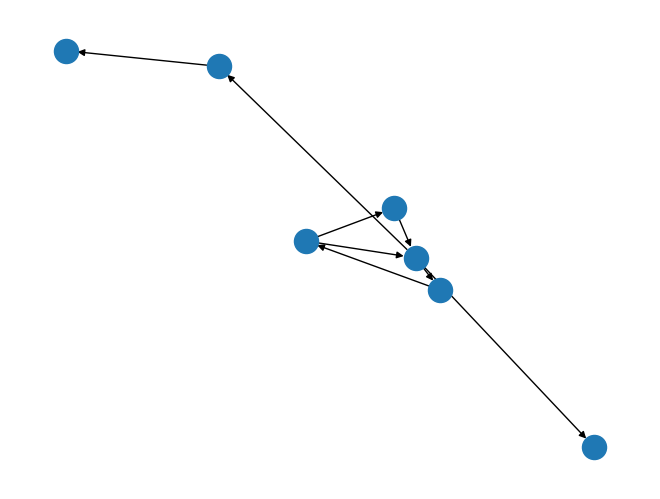

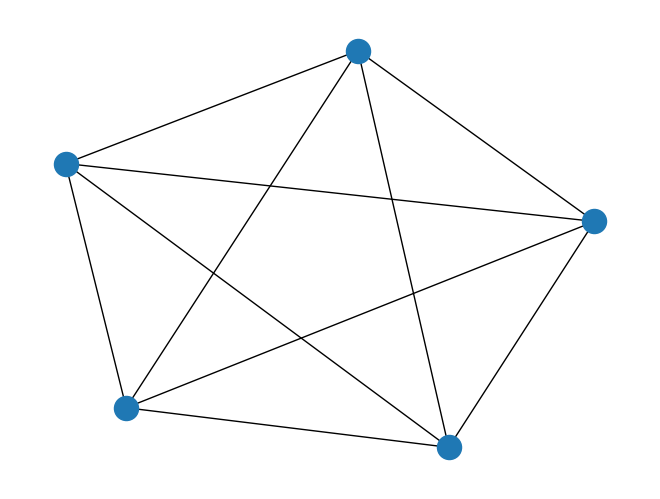

In [8]:
# Adjacency Matrix

# directed graph
G = nx.DiGraph()
G.add_nodes_from([1, 2, 3, 4, 5, 6])
nx.add_cycle(G, [1, 2, 3, 4])
G.add_edges_from([(1, 3), (3, 5), (3, 6), (6, 7)])
nx.draw(G)
plt.show()

# undirected graph
G = nx.complete_graph(5) # draws edges to and from all nodes
nx.draw(G)
plt.show()

eig_val[:10]:  [-1.69135539e-17  7.11275046e-04  7.51634068e-04  1.58207788e-03
  2.97001992e-03  3.05258264e-03  3.84548831e-03  4.06037024e-03
  4.87505152e-03  5.94930022e-03]
j:  1
[0.00071128 0.00075163]
[[ 4.91205538e+00 -1.34257189e-13]
 [-1.34243311e-13  5.00087435e+00]]


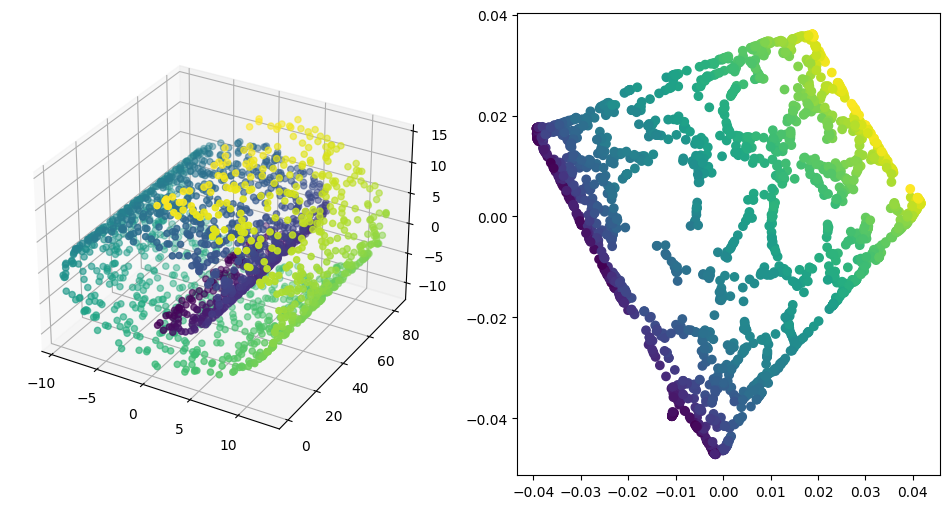

In [9]:
def make_swiss_roll(n_samples=100, noise=0.0, random_state=None):
    #Generate a swiss roll dataset.
    t = 1.5 * np.pi * (1 + 2 * np.random.rand(1, n_samples))
    x = t * np.cos(t)
    y = 83 * np.random.rand(1, n_samples)
    z = t * np.sin(t)
    X = np.concatenate((x, y, z))
    X += noise * np.random.randn(3, n_samples)
    X = X.T
    t = np.squeeze(t)
    return X, t

# rbf kernel function
def rbf(dist, t = 1.0):
    return np.exp(-(dist/t))

# calculate the Pairwise distance, x is matrix
# (a-b)^2 = a^2 + b^2 - 2*a*b
# returns the square of the distance between any two points
def cal_pairwise_dist(x):
    sum_x = np.sum(np.square(x), 1)
    dist = np.add(np.add(-2 * np.dot(x, x.T), sum_x).T, sum_x)
    return dist

def cal_rbf_dist(data, n_neighbors = 10, t = 1):
    dist = cal_pairwise_dist(data)
    dist[dist < 0] = 0
    n = dist.shape[0]
    rbf_dist = rbf(dist, t)
    W = np.zeros((n, n))
    for i in range(n):
        index_ = np.argsort(dist[i])[1:1+n_neighbors]
        W[i, index_] = rbf_dist[i, index_]
        W[index_, i] = rbf_dist[index_, i]
    return W

def le(data, n_dims = 2,
    n_neighbors = 5, t = 1.0):
    '''
    :param data: (n_samples, n_features)
    :param n_dims: target dim
    :param n_neighbors: k nearest neighbors
    :param t: a param for rbf
    :return:
    '''
    N = data.shape[0]
    W = cal_rbf_dist(data, n_neighbors, t)
    D = np.zeros_like(W)
    for i in range(N):
        D[i,i] = np.sum(W[i])

    D_inv = np.linalg.inv(D)
    L = D - W
    eig_val, eig_vec = np.linalg.eig(np.dot(D_inv, L))

    sort_index_ = np.argsort(eig_val)

    eig_val = eig_val[sort_index_]
    print("eig_val[:10]: ", eig_val[:10])

    j = 0
    while eig_val[j] < 1e-6:
        j+=1

    print("j: ", j)

    sort_index_ = sort_index_[j:j+n_dims]
    eig_val_picked = eig_val[j:j+n_dims]
    print(eig_val_picked)
    eig_vec_picked = eig_vec[:, sort_index_]

    print(np.dot(np.dot(eig_vec_picked.T, D), eig_vec_picked))

    X_ndim = eig_vec_picked
    return X_ndim

if __name__ == '__main__':
    X, Y = make_swiss_roll(n_samples = 2000)
    X_ndim = le(X, n_neighbors = 5, t = 20)

    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.scatter(X[:, 0], X[:, 1], X[:, 2], c = Y)

    ax2 = fig.add_subplot(122)
    ax2.scatter(X_ndim[:, 0], X_ndim[:, 1], c = Y)
    plt.show()